In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import glob as glob
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.crs as ccrs
# import cool_maps.plot as cplt
import cmocean.cm as cmo
import logging 
import bitstring
import time

start_lon = -86.5
end_lon = -85
filename = 'sfmc_simpleGyre.xml'
wheresave = '../SFMC_script/'
complete_filename = os.path.join(wheresave,filename)

def decimal_degrees_to_degrees_minutes(start_lon,end_lon):
    range_str = []
    unique_strings = []
    lon_map = []

    range_run = np.arange(start_lon, end_lon, 0.01) # range of numbers with 0.01 steps

    for i in range_run:
        deg = int(i)
        decimal_part = abs(i - deg)
        min = int(decimal_part * 60)
        # Formatting minutes to have leading zero if necessary
        min_str = f'{min:02d}'  # This ensures minutes are represented with leading zero if < 10
        string = f'{deg}{min_str}'

        # str = f'{deg}{min}'
        range_str.append(string)

    for string in range_str:
        if string not in unique_strings:
            unique_strings.append(string)
    
    # longitude strings to integers for mapping later
    for lon_str in unique_strings:
        londegstr = lon_str[1:3]  # Extracting degrees part without the negative sign
        lonminstr = lon_str[3:]   # Extracting minutes part for negative longitude
        lon_maploop = - (int(londegstr) + (int(lonminstr) / 60))

        lon_map.append(lon_maploop)

    return unique_strings,lon_map

# sections, 20, 20, 20, 15, 16
sec0 = 18
sec1 = 18
sec2 = 19
sec3 = 18
sec4 = 18

pltsec0 = 0
pltsec1 = sec0+sec1-1
pltsec2 = sec0+sec1+sec2-1
pltsec3 = sec0+sec1+sec2+sec3-1
pltsec4 = sec0+sec1+sec2+sec3+sec4-1

west0 = [45]*sec0
west1 = [90]*sec1
west2 = [135]*sec2
west3 = [180]*sec3
west4 = [225]*sec4

water_dir_deg = west0+west1+west2+west3+west4

rads = []
for i in water_dir_deg:
    rads_loop = math.radians(i)
    rads.append(rads_loop)

speed0 = [0.6]*sec0
speed1 = [0.4]*sec1
speed2 = [0.2]*sec2
speed3 = [0.4]*sec3
speed4 = [0.6]*sec4

water_speed = speed0 + speed1 + speed2 + speed3 + speed4

lon_range_str,lon_map = decimal_degrees_to_degrees_minutes(start_lon,end_lon)
loopnum = len(lon_range_str)
lat_map = [21]*len(lon_map)

print(f'Length of things should be equal: {len(lon_map)} = {len(lon_range_str)} = {len(rads)} = {len(water_speed)} = {len(lat_map)}')

Length of things should be equal: 91 = 91 = 91 = 91 = 91


In [3]:
# --- # LOGGING and HIDING UNDESIRABLE OUTPUT # --- #
_log = logging.getLogger(__name__)
# Define a custom filter to suppress specific log messages
class CustomFilter(logging.Filter):
    def filter(self, record):
        # Suppress log messages containing the specified text
        return "End of file reached without termination char" not in record.getMessage()

# Add the custom filter to the logger
_log.addFilter(CustomFilter())

# --- # DECODE THE BINARY DATA # --- #
def _decode_sensor_info(dfh, meta):
    """
    Helper to decode the sensor list.

    dfh must be a filehandle because we want to be able to say where we stopped
    in file.
    """

    nsensors_total = int(meta['total_num_sensors'])
    nsensors_used = int(meta['sensors_per_cycle'])
    activeSensorList = [{} for i in range(nsensors_used)]
    outlines = []
    sensorInfo = {}
    for i in range(nsensors_total):
        line = dfh.readline().decode('utf-8')
        if line.split(':')[0] != 's':
            raise ValueError('Failed to parse sensor info')
        splitLine = [string.strip() for string in line.split(' ')[1:]
                     if string and not string.isspace()]
        sensorInfo[splitLine[-2]] = splitLine
        if splitLine[0] == 'T':
            activeSensorList[int(splitLine[2])] = {
                'name': splitLine[-2], 'unit': splitLine[-1],
                'bits': splitLine[-3]}
        outlines = outlines + [line]

    bindatafilepos = dfh.tell()  # keep this for seeking

    return activeSensorList, sensorInfo, outlines, bindatafilepos
def _get_cached_sensorlist(cachedir, meta):
    """
    Helper to get the sensor list from a file in the cache
    """
    fname0 = cachedir + '/' + meta['sensor_list_crc'].upper() + '.CAC'
    dd = glob.glob(cachedir + '/*')
    found = False
    for d in dd:
        if (os.path.split(d)[1].upper() ==
                os.path.split(fname0)[1].upper()):
            found = True
            break
    if not found:
        raise FileNotFoundError(f'Could not find {fname0}')

    with open(d, 'rb') as dfh:
        activeSensorList, sensorInfo, outlines, bindatafilepos = \
                _decode_sensor_info(dfh, meta)

    return activeSensorList, sensorInfo
def _make_cache(outlines, cachedir, meta):
    """
    Helper to make a cache file if one doesn't exist.
    """
    try:
        os.mkdir(cachedir)
    except FileExistsError:
        pass

    fname = cachedir + '/' + meta['sensor_list_crc'] + '.CAC'
    with open(fname, 'w') as dfh:
        for line in outlines:
            dfh.write(line)
def dbd_get_meta(filename, cachedir):
    """
    Get metadata from a dinkum binary file.

    Parameters
    ----------

    filename : str
        filename of the dinkum binary file (i.e. *.dbd, *.ebd)

    cachedir : str
        Directory where the cached CAC sensor lists are kept.  These
        lists are often in directories like ``../Main_board/STATE/CACHE/``.
        These should be copied somewhere locally.  Recommend ``./cac/``.

    Returns
    -------
    meta : dict
        Dictionary of the meta data for this dinkum binary file.

    """

    meta = {}

    with open(filename, 'rb') as dfh:
        meta['num_ascii_tags'] = 99  # read the first 99 lines
        while (len(meta) < int(meta['num_ascii_tags'])):
            line = dfh.readline().decode('utf-8')
            meta[line.split(':')[0]] = line.split(':')[1].strip()
        if len(meta) != int(meta['num_ascii_tags']):
            raise ValueError('Did not find expected number of tags')
        bindatafilepos = dfh.tell()
        localcache = False
        # if the sensor data is here, we need to read it, even though we
        # will use the cache
        if ('sensor_list_factored' in meta and
                not int(meta['sensor_list_factored'])):
            localcache = True
            activeSensorList, sensorInfo, outlines, bindatafilepos = \
                _decode_sensor_info(dfh, meta)

        # read the cache first.  If its not there, try to make one....
        try:
            activeSensorList, sensorInfo = \
                _get_cached_sensorlist(cachedir, meta)
        except FileNotFoundError:
            if localcache:
                _log.info('No cache file found; trying to create one')
                _make_cache(outlines, cachedir, meta)
            else:
                raise FileNotFoundError(
                    'No active sensor list found for crc ',
                    f'{meta["sensor_list_crc"]}. These are often found in ',
                    'offloaddir/Science/STATE/CACHE/ or ',
                    'offloaddir/Main_board/STATE/CACHE/. ',
                    f'Copy those locally into {cachedir}')
        meta['activeSensorList'] = activeSensorList
        # get the file's timestamp...
        meta['_dbdfiletimestamp'] = os.path.getmtime(filename)

    return meta, bindatafilepos
def dbd_to_dict(dinkum_file, cachedir, keys=None):
    """
    Translate a dinkum binary file to a dictionary of data and meta values.

    Parameters
    ----------
    dinkum_file : dbd file name (full path)
        These are the raw data from the glider, either offloaded from a card
        or from the dockserver.

    cachedir : str
        Directory where the cached CAC sensor lists are kept.  These
        lists are often in directories like ``../Main_board/STATE/CACHE/``.
        These should be copied somewhere locally.  Recommend ``./cac/``.

    keys : list of str
        list of sensor names to include in the *data* dictionary.  This
        allows us to make the dictionaries more compact and not have
        all the redundant sensor info.  If a single string then keys is a
        file name and passed to  `~.slocum.parse_filter_file` to get the list
        of keys.

    Returns
    -------
    data : dict
        dictionary of all the data with sensor names as keys, filtered
        according to the *keys* kwarg.

    meta : dict
        dictionary of all the meta data in the file.

    """
    # Parse ascii header - read in the metadata.
    data = []
    DINKUMCHUNKSIZE = int(3e4)  # how much data to pre-allocate

    if isinstance(keys, str):
        keys = parse_filter_file(keys)

    meta, bindatafilepos = dbd_get_meta(dinkum_file, cachedir)
    activeSensorList = meta['activeSensorList']
    dfh = open(dinkum_file, 'rb')
    # ------------------------------------------
    # All subsequent lines are in binary format.
    # Grab the seek pos and use that for a bookmark.
    # ------------------------------------------
    # offset for number of characters already read in.
    _log.debug('reading file from %d', bindatafilepos * 8)
    binaryData = bitstring.BitStream(dfh, offset=bindatafilepos * 8)
    # First there's the s,a,2byte int, 4 byte float, 8 byte double.
    # sometimes the endianess seems to get swapped.
    # ref_tuple = ['s', 'a', 4660, 123.456, 123456789.12345]
    diag_header = binaryData.readlist(['bits:8', 'bits:8'])
    diag_header[0] = chr(int(diag_header[0].hex, 16))
    diag_header[1] = chr(int(diag_header[1].hex, 16))
    if not (diag_header[0] == 's') and (diag_header[1] == 'a'):
        _log.warning("character failure: %s != 's', 'a'", diag_header)
        raise ValueError('Diagnostic header check failed.')

    endian = 'be'
    data = binaryData.read(f'uint{endian}:16')
    _log.debug('Checking endianness %s == 4660 or 13330', data)
    if data == 4660:
        pass
    elif data == 13330:
        endian = 'le'
    else:
        _log.warning("integer failure: %s != 4660", data)
        raise ValueError("Diagnostic header check failed.")
    _log.debug('Endianness is %s', endian)

    data = binaryData.read(f'float{endian}:32')
    if not np.allclose(data, 123.456):
        _log.warning("float32 failure: %s != 123.456", data)
        raise ValueError("Diagnostic header check failed.")

    data = binaryData.read(f'float{endian}:64')
    if not np.allclose(data, 123456789.12345):
        _log.warning("float64 failure: %s != 123456789.12345", data)
        raise ValueError("Diagnostic header check failed.")
    _log.debug('Diagnostic check passed.  Endian is %s', endian)

    nsensors = int(meta['sensors_per_cycle'])
    currentValues = np.zeros(int(meta['sensors_per_cycle'])) + np.NaN
    data = np.zeros((DINKUMCHUNKSIZE, nsensors)) + np.NaN
    # Then there's a data cycle with every sensor marked as updated, giving
    # us our initial values.
    # 01 means updated with 'same value', 10 means updated with a new value,
    # 11 is reserved, 00 is not updated.
    # This character leads off each byte cycle.
    frameCheck = binaryData.read('bytes:1').decode("utf-8")
    updatedCode = ['00'] * int(meta['sensors_per_cycle'])

    # Data cycle begins now.
    # Cycle tag is a ascii 'd' character. Then
    # state_bytes_per_cycle * state_bytes (2bits per sensor) of state bytes.
    # Then data for each updated sensor as per the state bytes.
    # Then zeroes until the last byte is completed, should they be necessary.
    _log.info('Parsing binary data')
    proctimestart = time.time()
    ndata = 0
    while frameCheck == 'd':
        for i in range(int(meta['sensors_per_cycle'])):
            updatedCode[i] = binaryData.read('bin:2')
        # burn off any remaining bits to get to the first full bit.
        binaryData.bytealign()
        for i, code in enumerate(updatedCode):
            if code == '00':  # No new value
                currentValues[i] = np.NaN
            elif code == '01':  # Same value as before.
                continue
            elif code == '10':  # New value.
                if int(activeSensorList[i]['bits']) in [4, 8]:
                    currentValues[i] = binaryData.read(
                        f'float{endian}:' +
                        str(int(activeSensorList[i]['bits']) * 8))
                elif int(activeSensorList[i]['bits']) in [1, 2]:
                    currentValues[i] = binaryData.read(
                        f'uint{endian}:' +
                        str(int(activeSensorList[i]['bits']) * 8))
                else:
                    raise ValueError('Bad bits')
            else:
                raise ValueError(('Unrecognizable code in data cycle. ',
                                  'Parsing failed'))
        data[ndata] = currentValues
        binaryData.bytealign()

        # We've arrived at the next line.
        try:
            d = binaryData.peek('bytes:1').decode('utf-8')
        except bitstring.ReadError:
            _log.debug('position at end of stream %d',
                       binaryData.pos + 8 * bindatafilepos)
            _log.warning('End of file reached without termination char')
            d = 'X'
        if d == 'd':
            frameCheck = binaryData.read('bytes:1').decode('utf-8')
            ndata += 1
            if ndata % DINKUMCHUNKSIZE == 0:
                # need to allocate more data!
                data = np.concatenate(
                    (data, np.NaN + np.zeros((DINKUMCHUNKSIZE, nsensors))),
                    axis=0)
        elif d == 'X':
            # End of file cycle tag. We made it through.
            # throw out pre-allocated data we didn't use...
            data = data[:ndata]
            break
        else:
            raise ValueError(f'Parsing failed at {binaryData.bytepos}. ',
                             f'Got {d} expected d or X')

    proctimeend = time.time()

    # THIS WAS GIVING ERRORS AS THE TIME WAS DIVIDING BY ZERO, seems to work without?
    # _log.info(('%s lines of data read from %s, data rate of %s rows '
    #            'per second') % (len(data), dinkum_file,
    #                             len(data) / (proctimeend - proctimestart)))
    # dfh.close()

    _log.info('Putting data into dictionary')
    ddict = dict()

    # deal 2-D array into a dictionary...  Only keep keys we want...
    for n, key in enumerate(meta['activeSensorList']):
        if keys is None or key['name'] in keys:
            ddict[key['name']] = data[:, n]

    return ddict, meta
# --- #          https://github.com/c-proof/pyglider/blob/main/pyglider/slocum.py         # --- #
# --- # I commented out part of dbd_to_dict due to ZeroDivisionErrors (lines 309-312) # --- #

# this is for the alphanum_key at the end of the initial glob data ingest
# process numbered files in the way a human would think to do it, nicely and numerically
###############################################################################
def tryint(s):
    """
    Return an int if possible, or `s` unchanged.
    """
    try:
        return int(s)
    except ValueError:
        return s
def alphanum_key(s):
    """
    Turn a string into a list of string and number chunks.
    >>> alphanum_key("z23a")
    ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]
def human_sort(l):
    """
    Sort a list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
# --- # # from https://nedbatchelder.com/blog/200712/human_sorting.html # --- #

# process strings from glider into numbers for plotting
# convert lmc coordinates to lat and lon using initial location and distance from
def str2num_north_west_ru17(lat_str,lon_str):
    """
    Docstring: Converts glider lat/lon coords to decimals, then processes into Pandas dataframe. 

    Parameters:
    - parameter1 (str): latitude strings from [m_lat]
    - parameter2 (str): longitude strings from [m_lon]
    ...

    Returns:
    type: Float lat, lon, indexed by time. 
    """
    lat = []
    lon = []

    for i in range(len(lat_str)): 
        
        # latitude strings
        latdegstr = str(lat_str[i])[0:2]    # first 2
        latminstr = str(lat_str[i])[2:]     # everything but first 2

        # latitude strings to integers for mapping 
        latmaploop = (float(latdegstr)) + ((float(latminstr)))/60
        lat.append(latmaploop)

    for i in range(len(lon_str)-1):
        # longitude strings
        londegstr = str(lon_str[i])[1:3]
        lonminstr = str(lon_str[i])[3:]

        # longitude strings to integers for mapping 
        lonmaploop = (float(londegstr)) + ((float(lonminstr)))/60
        lon.append(-lonmaploop)

    coords = pd.DataFrame()     # put the above into final dataframe

    # Check the lengths of lat and lon
    print(f"Length of 'lat': {len(lat)}")
    print(f"Length of 'lon': {len(lon)}")

    coords['lat'] = lat
    coords['lon'] = lon
    data_length = len(coords)
    print(f"Length of DataFrame: {data_length}")

    # coords = coords.set_index(lat_str.index)
    data_length = len(lat) 
    coords = coords.set_index(pd.RangeIndex(start=0, stop=data_length, step=1))
    
    # Return statement: If the function returns a value
    return coords

def str2num_north_west_spec(lat_str,lon_str):
    """
    Docstring: Converts glider lat/lon coords to decimals, then processes into Pandas dataframe. 

    Parameters:
    - parameter1 (str): latitude strings from [m_lat]
    - parameter2 (str): longitude strings from [m_lon]
    ...

    Returns:
    type: Float lat, lon, indexed by time. 
    """
    lat = []
    lon = []

    for i in range(len(lat_str)-18): 
        
        # latitude strings
        latdegstr = str(lat_str[i])[0:2]    # first 2
        latminstr = str(lat_str[i])[2:]     # everything but first 2

        # latitude strings to integers for mapping 
        latmaploop = (float(latdegstr)) + ((float(latminstr)))/60
        lat.append(latmaploop)

    for i in range(len(lon_str)-1):
        # longitude strings
        londegstr = str(lon_str[i])[1:3]
        lonminstr = str(lon_str[i])[3:]

        # longitude strings to integers for mapping 
        lonmaploop = (float(londegstr)) + ((float(lonminstr)))/60
        lon.append(-lonmaploop)

    coords = pd.DataFrame()     # put the above into final dataframe

    # Check the lengths of lat and lon
    print(f"Length of 'lat': {len(lat)}")
    print(f"Length of 'lon': {len(lon)}")

    coords['lat'] = lat
    coords['lon'] = lon
    data_length = len(coords)
    print(f"Length of DataFrame: {data_length}")

    # coords = coords.set_index(lat_str.index)
    data_length = len(lat) 
    coords = coords.set_index(pd.RangeIndex(start=0, stop=data_length, step=1))
    
    # Return statement: If the function returns a value
    return coords


def lmc2deg(x_lmc, lat, lon):
    """
    Convert linear distance in meters (both latitude and longitude) to angular distance in degrees using geopy.

    Parameters:
    - x_lmc: Linear distance in meters for longitude.
    - y_lmc: Linear distance in meters for latitude.
    - lat: Latitude of the location in degrees.
    - lon: Longitude of the location in degrees.

    Returns:
    - lmc_lat: Angular distance in degrees for latitude.
    - lmc_lon: Angular distance in degrees for longitude.
    """
    # Convert linear distances to kilometers
    # lat_km = y_lmc / 1000.0
    lat_km = 0
    lon_km = x_lmc / 1000.0

    # Use geopy to calculate the destination points for both latitude and longitude
    dest_lat = geodesic(kilometers=lat_km).destination(point=(lat, lon), bearing=0)
    dest_lon = geodesic(kilometers=lon_km).destination(point=(lat, lon), bearing=90)

    # Get the latitude and longitude of the destination points
    lmc_lat = dest_lat.latitude
    lmc_lon = dest_lon.longitude

    # Get the latitude and longitude of the destination points
    lmc_lat = dest_lat.latitude
    lmc_latbot = lmc_lat - 5
    lmc_lattop = lmc_lat + 5

    lat = (lmc_latbot,lmc_lattop)
    lon = (lmc_lon,lmc_lon)

    return lat,lon
# --- # Made by me # --- #

# create list of all files in folder
sbd_raw_ru17  = sorted(glob.glob('../SFMC_script/ru17_sbd_simpleGyre/ru17_ghost-2023-361*.sbd'),key=alphanum_key)
sbd_raw_spec  = sorted(glob.glob('../SFMC_script/spectre_sbd_simpleGyre/spectre-2023-361-2*.sbd'),key=alphanum_key)

# init final Pandas dataframe
final_ru17 = pd.DataFrame()
final_spec = pd.DataFrame()

# how many times to loop through and append data
loopnum_ru17 = range(0,len(sbd_raw_ru17))
loopnum_spec = range(0,len(sbd_raw_spec))
print(f'Files to process: {len(sbd_raw_ru17)} and {len(sbd_raw_spec)}') # visual check
loopdisp = 1 # init

# need to look through ^ files and put into one dataframe 
for i in loopnum_ru17:

    sbd_file = sbd_raw_ru17[i]
    # tbd_file = tbd_raw[i]

    # where are the cac files
    sbd,sbd_meta = dbd_to_dict(sbd_file,'../process_glider_files/rutgers-cac/')
    # tbd,tbd_meta = dbd_to_dict(tbd_file,'../process_glider_files/rutgers-cac/')

    # imports the data into two Pandas DataFrames using proper time for type of file
    sbd = pd.DataFrame.from_dict(sbd, orient='columns', dtype=None, columns=None).set_index('m_present_time')
    # tbd = pd.DataFrame.from_dict(tbd, orient='columns', dtype=None, columns=None).set_index('sci_m_present_time')

    # cleans up the DataFrame time indices.
    sbd.index = pd.to_datetime(sbd.index,unit='s').round(freq='S')
    # tbd.index = pd.to_datetime(tbd.index,unit='s').round(freq='S')

    # combines them into one DataFrame
    # data = pd.concat([tbd, sbd]).sort_index()
    data = pd.concat([sbd]).sort_index()

    # append data to the final dataframe
    # this is what combines each file's segmement into one dataframe 
    final_ru17 = pd.concat([final_ru17, data])

lat_str = (final_ru17['m_lat'].dropna()) 
lon_str = (final_ru17['m_lon'].dropna())
coords_ru17 = str2num_north_west_ru17(lat_str,lon_str)
lon_glider_ru17 = coords_ru17['lon']
lat_glider_ru17 = coords_ru17['lat']

for i in loopnum_spec:

    sbd_file = sbd_raw_spec[i]
    # tbd_file = tbd_raw[i]

    # where are the cac files
    sbd,sbd_meta = dbd_to_dict(sbd_file,'../process_glider_files/rutgers-cac/')
    # tbd,tbd_meta = dbd_to_dict(tbd_file,'../process_glider_files/rutgers-cac/')

    # imports the data into two Pandas DataFrames using proper time for type of file
    sbd = pd.DataFrame.from_dict(sbd, orient='columns', dtype=None, columns=None).set_index('m_present_time')
    # tbd = pd.DataFrame.from_dict(tbd, orient='columns', dtype=None, columns=None).set_index('sci_m_present_time')

    # cleans up the DataFrame time indices.
    sbd.index = pd.to_datetime(sbd.index,unit='s').round(freq='S')
    # tbd.index = pd.to_datetime(tbd.index,unit='s').round(freq='S')

    # combines them into one DataFrame
    # data = pd.concat([tbd, sbd]).sort_index()
    data = pd.concat([sbd]).sort_index()

    # append data to the final dataframe
    # this is what combines each file's segmement into one dataframe 
    final_spec = pd.concat([final_spec, data])

lat_str_spec = (final_spec['m_lat'].dropna()) 
lon_str_spec = (final_spec['m_lon'].dropna())
coords_spec = str2num_north_west_spec(lat_str_spec,lon_str_spec)
lon_glider_spec = coords_spec['lon']
lat_glider_spec = coords_spec['lat']

t_ru17 = final_ru17.index.max() - final_ru17.index.min()
t_spec = final_spec.index.max() - final_spec.index.min()

Files to process: 33 and 33
Length of 'lat': 2925
Length of 'lon': 2925
Length of DataFrame: 2925
Length of 'lat': 11104
Length of 'lon': 11104
Length of DataFrame: 11104


In [70]:
# def str2num_north_west(lat_str,lon_str):
#     lat = []
#     lon = []

#     for i in range(len(lat_str)-17): 
#         # latitude strings
#         latdegstr = str(lat_str[i])[0:2]    # first 2
#         latminstr = str(lat_str[i])[2:]     # everything but first 2

#         # latitude strings to integers for mapping 
#         latmaploop = (float(latdegstr)) + ((float(latminstr)))/60
#         lat.append(latmaploop)

#     for i in range(len(lon_str)):
#         # longitude strings
#         londegstr = str(lon_str[i])[1:3]
#         lonminstr = str(lon_str[i])[3:]

#         # longitude strings to integers for mapping 
#         lonmaploop = (float(londegstr)) + ((float(lonminstr)))/60
#         lon.append(-lonmaploop)

#     coords = pd.DataFrame()     # put the above into final dataframe
#     coords['lat'] = lat
#     print(len(lon))
#     print(len(lat))
#     coords['lon'] = lon
#     # coords = coords.set_index(lat_str.index)

#     coords = coords.set_index(pd.RangeIndex(start=0, stop=len(lon), step=1))
    
#     # Return statement: If the function returns a value
#     return coords

# lat_str_spec = (final_spec['m_lat'].dropna()) 
# lon_str_spec = (final_spec['m_lon'].dropna())
# coords_spec = str2num_north_west(lat_str_spec,lon_str_spec)
# coords_spec

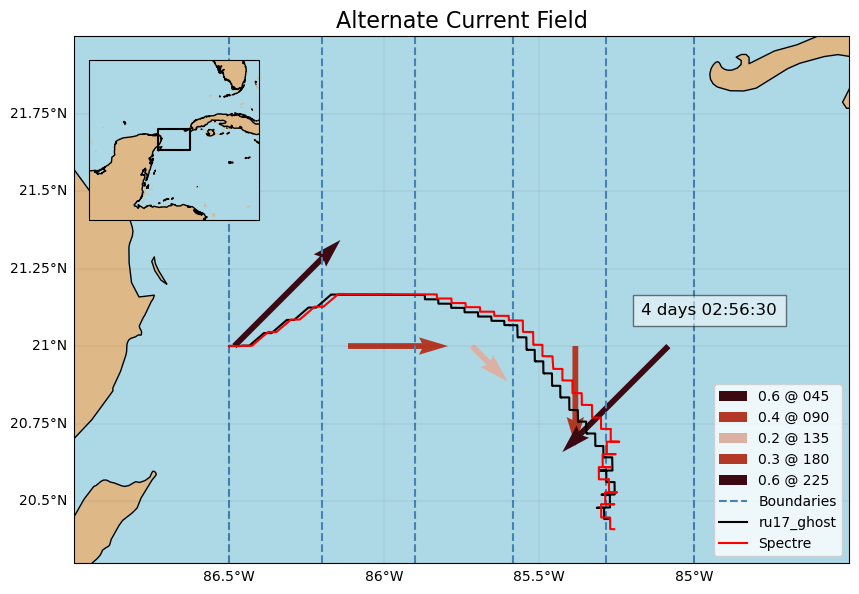

In [5]:
lon_ext = [-86.5,-85]
lat_ext = [21.5,20.8] 

# Create a map using PlateCarree projection (latitude and longitude)
fig, ax = plt.subplots(figsize=(10,20),subplot_kw={'projection': ccrs.PlateCarree()})
# fig, ax = cplt.create(extent, proj=ccrs.Mercator(), bathymetry=False, figsize=(10,20))

buffer = 0.5
# Set the extent of the map based on the trackline data
ax.set_extent([min(lon_ext) - buffer,
                max(lon_ext) + buffer, 
                min(lat_ext) - buffer, 
                max(lat_ext) + buffer
                ])

# Add coastlines
ax.coastlines()
ax.add_feature(cfeature.LAND, color='burlywood') # I like this color
ax.add_feature(cfeature.OCEAN, color='lightblue')

gl = ax.gridlines(draw_labels=True, linewidth=0.1, color='black', alpha=0.5, linestyle='-')
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right labels

# remove labels from ax.gridlines
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# remove labels from cartopy
ax.set_xticklabels([])
ax.set_yticklabels([])

color = 'steelblue'
# sections, 20, 20, 20, 15, 16
ax.axvline(lon_map[sec0], color=color, linestyle='--')
ax.axvline(lon_map[sec0+sec1], color=color, linestyle='--')
ax.axvline(lon_map[sec0+sec1+sec2], color=color, linestyle='--')
ax.axvline(lon_map[sec0+sec1+sec2+sec3], color=color, linestyle='--')
ax.axvline(lon_map[sec0+sec1+sec2+sec3+sec4-1], color=color, linestyle='--')

# Convert direction and magnitude to components (u, v)
u_list = []  # Empty list to store u components
v_list = []  # Empty list to store v components

for speed, rad in zip(water_speed, rads):
    # Adjust the angles for the quiver plot if needed
    adjusted_rads = [np.pi / 2 - angle for angle in rads]
    
    u = speed * np.cos(adjusted_rads)
    v = speed * np.sin(adjusted_rads)
    u_list.append(u)
    v_list.append(v)
    
scale = 3.1 # bigger num is smaller

# Define colormap
cmap = cmo.amp
# cmap = cmap.reversed()

# Define the range of values corresponding to the colormap
pltspeed_values = [0.1, 0.3, 0.4, 0.6]  

# # Create a scalar mappable for colorbar
norm = plt.Normalize(min(pltspeed_values), max(pltspeed_values))
scalar_mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scalar_mappable.set_array([])  # Set an empty array

# Plot the quiver plots using colormap
quiver0 = ax.quiver(lon_map[1], lat_map[1], u_list[pltsec0][pltsec0], v_list[pltsec0][pltsec0],
                    angles='xy', color=cmap(norm(0.6)), transform=ccrs.PlateCarree(), scale=scale, label='0.6 @ 045')
quiver1 = ax.quiver(lon_map[23], lat_map[1], u_list[pltsec1][pltsec1], v_list[pltsec1][pltsec1],
                    angles='xy', color=cmap(norm(0.4)), transform=ccrs.PlateCarree(), scale=scale, label='0.4 @ 090')
quiver2 = ax.quiver(lon_map[47], lat_map[1], u_list[pltsec2][pltsec2], v_list[pltsec2][pltsec2],
                    angles='xy', color=cmap(norm(0.2)), transform=ccrs.PlateCarree(), scale=scale, label='0.2 @ 135')
quiver3 = ax.quiver(lon_map[67], lat_map[1], u_list[pltsec3][pltsec3], v_list[pltsec3][pltsec3],
                    angles='xy', color=cmap(norm(0.4)), transform=ccrs.PlateCarree(), scale=scale, label='0.3 @ 180')
quiver4 = ax.quiver(lon_map[85], lat_map[1], u_list[pltsec4][pltsec4], v_list[pltsec4][pltsec4],
                    angles='xy', color=cmap(norm(0.6)), transform=ccrs.PlateCarree(), scale=scale, label='0.6 @ 225')


plt.title('Alternate Current Field',fontsize=16)
# this at end for bottom of legend
ax.axvline(lon_map[0], color='steelblue', linestyle='--',label='Boundaries')

# locator map
# left, bottom, width, height
ax_locator = fig.add_axes([0.14, 0.49, 0.17, 0.17], projection=ccrs.PlateCarree())

big_extent_buff = 6
big_extent = ([min(lon_ext) - big_extent_buff,
                max(lon_ext) + big_extent_buff,
                min(lat_ext) - big_extent_buff,
                max(lat_ext) + big_extent_buff])
# set extent for the locator map
ax_locator.set_extent(big_extent)
ax_locator.add_feature(cfeature.COASTLINE, edgecolor='black')
ax_locator.add_feature(cfeature.OCEAN, color='lightblue')
ax_locator.add_feature(cfeature.LAND, color='burlywood')

# ax.scatter(lon_glider, lat_glider, marker='.', s=20, alpha=0.5, cmap='cool', transform=ccrs.PlateCarree())
ax.plot(lon_glider_ru17, lat_glider_ru17, linewidth=1.5, color='black', transform=ccrs.PlateCarree(),label='ru17_ghost')
ax.plot(lon_glider_spec, lat_glider_spec, linewidth=1.5, color='red', transform=ccrs.PlateCarree(),label='Spectre')
# ax.plot(lon_glider_spec1, lat_glider_spec1, linewidth=1.5, color='forestgreen', transform=ccrs.PlateCarree(),label='Backseat Driver')

## Box around actual figure region
ax_locator.plot([min(lon_ext) - buffer, min(lon_ext) - buffer,  max(lon_ext) + buffer, max(lon_ext) + buffer, min(lon_ext) - buffer] , 
        [min(lat_ext) - buffer, max(lat_ext) + buffer, max(lat_ext) + buffer, min(lat_ext) - buffer, min(lat_ext) - buffer], color='black',linewidth=1.5,  transform=ccrs.PlateCarree())

ax.set_extent([min(lon_ext) - buffer,
                max(lon_ext) + buffer, 
                min(lat_ext) - buffer, 
                max(lat_ext) + buffer
                ])

ax.legend(loc='lower right')
bbox_time = dict(boxstyle='square,pad=0.5', facecolor='white', alpha=0.5)  # Semi-transparent white box
# ax.text(-85.2,21.65,f'{t_ru17}',fontsize=12,bbox=bbox_time)      
ax.text(-85.17,21.1,f'{t_spec}',fontsize=12,bbox=bbox_time)    

plt.savefig(os.path.join(wheresave,'simpleGyre.png'), dpi=300, bbox_inches='tight')
# filename = os.path.join(wheresave,'sendWaterSpeedDir.png')
# print(f'plot_fzb saved: {filename}')

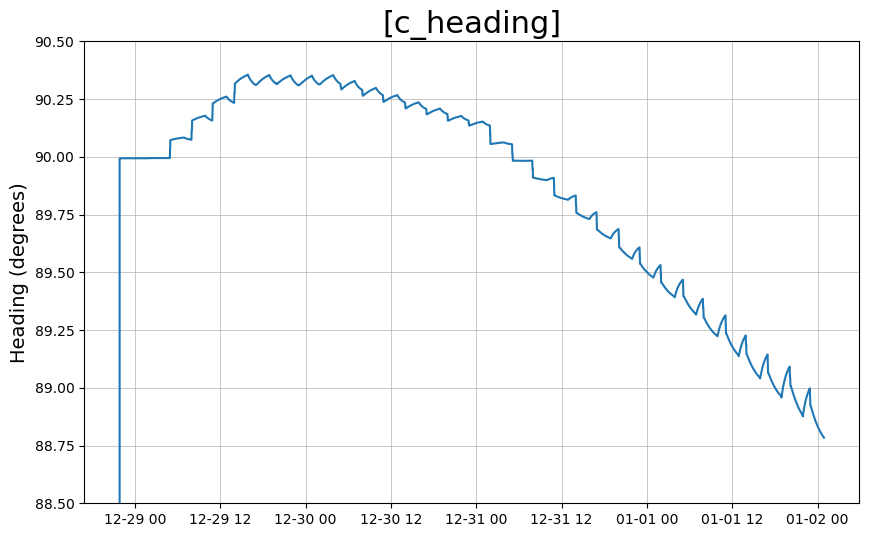

In [82]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(np.rad2deg(final_ru17['c_heading'].dropna()))
ax.set_xlabel('',fontsize=14)
ax.set_ylabel('Heading (degrees)',fontsize=14)
ax.set_title('[c_heading]',fontsize=22)
ax.grid(linewidth=0.5)
ax.set_ylim(88.5,90.5)
plt.show()

In [89]:
# hit run a few times because it does this so fast it messes up someohow

header = (
    '<gliderScript>\n\n'
    )

checkNoComms = (
    '    <!-- The start state of the script. -->\n'
    '    <initialState name="checkNoComms">\n'
    '        <transitions>\n'
    '            <!-- Must wait for glider to calculate water velocity! Send to to sendWaterSpeedDir -->\n'
    '            <transition matchExpression="Calculations COMPLETE" toState="sendWaterSpeedDir">\n'
    '            </transition>\n'
    '        </transitions>\n'
    '    </initialState>\n\n')

sendWaterSpeedDirHeader = (
    '<!-- From checkNoComms. This sends updated current direction before sendResume. This state "simulates" a current field\n'
    '    by matching the longitude from surface dialogs, then !put s_water_direction and s_water_speed to what it should be for\n'
    '    the location of the glider before diving. It only reads the logitude part of the surface dialog, from following part\n'
    '    in quotes: sensor:m_lon(lon)=\'-8630\'\n'
    '    -->\n'
    '    <state name="sendWaterSpeedDir">\n'
    '        <transitions>\n')

footer = (
    '<!-- SEND RESUME/DIVE ========================================= -->\n'
    '    <state name="sendResume">\n'
    '        <transitions>\n'
    '            <transition matchExpression="xxx command verify fail xxx" toState="sendResume">\n'
    '            </transition>\n'
    '            <!-- Ready to dive, but send report first! MUST SEND TWO CTLR-R\'S OR ELSE IT DOESN\'T WORK\n'
    '                 Script needs more time after the !put so sends two -->\n'
    '            <transition matchExpression="Hit Control-R to RESUME" toState="checkNoComms">\n'
    '                <action type="glider" command="Ctrl-R">\n'
    '                </action>\n'
    '                <action type="glider" command="Ctrl-R">\n'
    '                </action>\n'
    '            </transition>\n'
    '            <transition timeout="10" toState="checkNoComms">\n'
    '            </transition>\n'
    '        </transitions>\n'
    '    </state>\n'
    '\n'
    '    <finalState name="final">\n'
    '    </finalState>\n'
    '</gliderScript>\n')

file = open(complete_filename, 'w')
file.write(header)
file.write(checkNoComms)
file.write(sendWaterSpeedDirHeader)
for zz in range(0, loopnum):
    # file.write(f'           <transition matchExpression="   sensor:m_lon(lon)={lon_range_str[zz]}" toState="sendResume">\n')
    file.write(f'           <transition matchExpression="={lon_range_str[zz]}" toState="sendResume">\n')
    file.write(f'              <action type="glider" command="!put s_water_direction {rads[zz]}">\n') 
    file.write('              </action>\n')
    file.write(f'              <action type="glider" command="!put s_water_speed {water_speed[zz]}">\n')
    file.write('              </action>\n')
    file.write('            </transition>\n')
file.write('       </transitions>\n')
file.write('   </state>\n')
file.write('\n')
file.write(footer)


880

In [85]:
# lon_ext = [-86.5,-85]
# lat_ext = [21.5,20.8] 

# # Create a map using PlateCarree projection (latitude and longitude)
# fig, ax = plt.subplots(figsize=(10,20),subplot_kw={'projection': ccrs.PlateCarree()})
# # fig, ax = cplt.create(extent, proj=ccrs.Mercator(), bathymetry=False, figsize=(10,20))

# buffer = 0.5
# # Set the extent of the map based on the trackline data
# ax.set_extent([min(lon_ext) - buffer,
#                 max(lon_ext) + buffer, 
#                 min(lat_ext) - buffer, 
#                 max(lat_ext) + buffer
#                 ])

# # Add coastlines
# ax.coastlines()
# ax.add_feature(cfeature.LAND, color='burlywood') # I like this color
# ax.add_feature(cfeature.OCEAN, color='lightblue')

# gl = ax.gridlines(draw_labels=True, linewidth=0.1, color='black', alpha=0.5, linestyle='-')
# gl.top_labels = False  # Remove top labels
# gl.right_labels = False  # Remove right labels

# # remove labels from ax.gridlines
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')

# # remove labels from cartopy
# ax.set_xticklabels([])
# ax.set_yticklabels([])

# color = 'steelblue'
# # sections, 20, 20, 20, 15, 16
# ax.axvline(lon_map[sec0], color=color, linestyle='--')
# ax.axvline(lon_map[sec0+sec1], color=color, linestyle='--')
# ax.axvline(lon_map[sec0+sec1+sec2], color=color, linestyle='--')
# ax.axvline(lon_map[sec0+sec1+sec2+sec3], color=color, linestyle='--')
# ax.axvline(lon_map[sec0+sec1+sec2+sec3+sec4-1], color=color, linestyle='--')

# # Convert direction and magnitude to components (u, v)
# u_list = []  # Empty list to store u components
# v_list = []  # Empty list to store v components

# for speed, rad in zip(water_speed, rads):
#     # Adjust the angles for the quiver plot if needed
#     adjusted_rads = [np.pi / 2 - angle for angle in rads]
    
#     u = speed * np.cos(adjusted_rads)
#     v = speed * np.sin(adjusted_rads)
#     u_list.append(u)
#     v_list.append(v)
    
# scale = 3.1 # bigger num is smaller

# # Define colormap
# cmap = cmo.amp
# # cmap = cmap.reversed()

# # Define the range of values corresponding to the colormap
# pltspeed_values = [0.1, 0.3, 0.4, 0.6]  

# # # Create a scalar mappable for colorbar
# norm = plt.Normalize(min(pltspeed_values), max(pltspeed_values))
# scalar_mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# scalar_mappable.set_array([])  # Set an empty array

# # Plot the quiver plots using colormap
# quiver0 = ax.quiver(lon_map[1], lat_map[1], u_list[pltsec0][pltsec0], v_list[pltsec0][pltsec0],
#                     angles='xy', color=cmap(norm(0.6)), transform=ccrs.PlateCarree(), scale=scale, label='0.6 @ 045')
# quiver1 = ax.quiver(lon_map[23], lat_map[1], u_list[pltsec1][pltsec1], v_list[pltsec1][pltsec1],
#                     angles='xy', color=cmap(norm(0.4)), transform=ccrs.PlateCarree(), scale=scale, label='0.4 @ 030')
# quiver2 = ax.quiver(lon_map[47], lat_map[1], u_list[pltsec2][pltsec2], v_list[pltsec2][pltsec2],
#                     angles='xy', color=cmap(norm(0.3)), transform=ccrs.PlateCarree(), scale=scale, label='0.3 @ 020')
# quiver3 = ax.quiver(lon_map[67], lat_map[1], u_list[pltsec3][pltsec3], v_list[pltsec3][pltsec3],
#                     angles='xy', color=cmap(norm(0.1)), transform=ccrs.PlateCarree(), scale=scale, label='0.1 @ 000')
# quiver4 = ax.quiver(lon_map[85], lat_map[1], u_list[pltsec4][pltsec4], v_list[pltsec4][pltsec4],
#                     angles='xy', color=cmap(norm(0.3)), transform=ccrs.PlateCarree(), scale=scale, label='0.3 @ 340')


# plt.title('new_water_map',fontsize=16)
# # this at end for bottom of legend
# ax.axvline(lon_map[0], color='steelblue', linestyle='--',label='Boundaries')

# # locator map
# # left, bottom, width, height
# ax_locator = fig.add_axes([0.14, 0.49, 0.17, 0.17], projection=ccrs.PlateCarree())

# big_extent_buff = 6
# big_extent = ([min(lon_ext) - big_extent_buff,
#                 max(lon_ext) + big_extent_buff,
#                 min(lat_ext) - big_extent_buff,
#                 max(lat_ext) + big_extent_buff])
# # set extent for the locator map
# ax_locator.set_extent(big_extent)
# ax_locator.add_feature(cfeature.COASTLINE, edgecolor='black')
# ax_locator.add_feature(cfeature.OCEAN, color='lightblue')
# ax_locator.add_feature(cfeature.LAND, color='burlywood')

# # ax.scatter(lon_glider, lat_glider, marker='.', s=20, alpha=0.5, cmap='cool', transform=ccrs.PlateCarree())
# # ax.plot(lon_glider_e, lat_glider_e, linewidth=1.5, color='black', transform=ccrs.PlateCarree(),label='Due east')
# # ax.plot(lon_glider_se, lat_glider_se, linewidth=1.5, color='red', transform=ccrs.PlateCarree(),label='Southeast')
# # ax.plot(lon_glider_spec1, lat_glider_spec1, linewidth=1.5, color='forestgreen', transform=ccrs.PlateCarree(),label='Backseat Driver')

# ## Box around actual figure region
# ax_locator.plot([min(lon_ext) - buffer, min(lon_ext) - buffer,  max(lon_ext) + buffer, max(lon_ext) + buffer, min(lon_ext) - buffer] , 
#         [min(lat_ext) - buffer, max(lat_ext) + buffer, max(lat_ext) + buffer, min(lat_ext) - buffer, min(lat_ext) - buffer], color='black',linewidth=1.5,  transform=ccrs.PlateCarree())

# ax.set_extent([min(lon_ext) - buffer,
#                 max(lon_ext) + buffer, 
#                 min(lat_ext) - buffer, 
#                 max(lat_ext) + buffer
#                 ])

# ax.legend(loc='lower right')
# bbox_time = dict(boxstyle='square,pad=0.5', facecolor='white', alpha=0.5)  # Semi-transparent white box
# # ax.text(-85.2,21.65,f'{t_e}',fontsize=12,bbox=bbox_time)     # due east time
# # ax.text(-85.17,21.1,f'{t_se}',fontsize=12,bbox=bbox_time)     # southeast time
# # ax.text(-85,21.4,f'{t_spec1}',fontsize=12,bbox=bbox_time) # spec1 time

# plt.savefig(os.path.join(wheresave,'new_water_map.png'), dpi=300, bbox_inches='tight')
# # filename = os.path.join(wheresave,'sendWaterSpeedDir.png')
# # print(f'plot_fzb saved: {filename}')

Length of things should be equal: 91 = 91 = 91 = 91 = 91


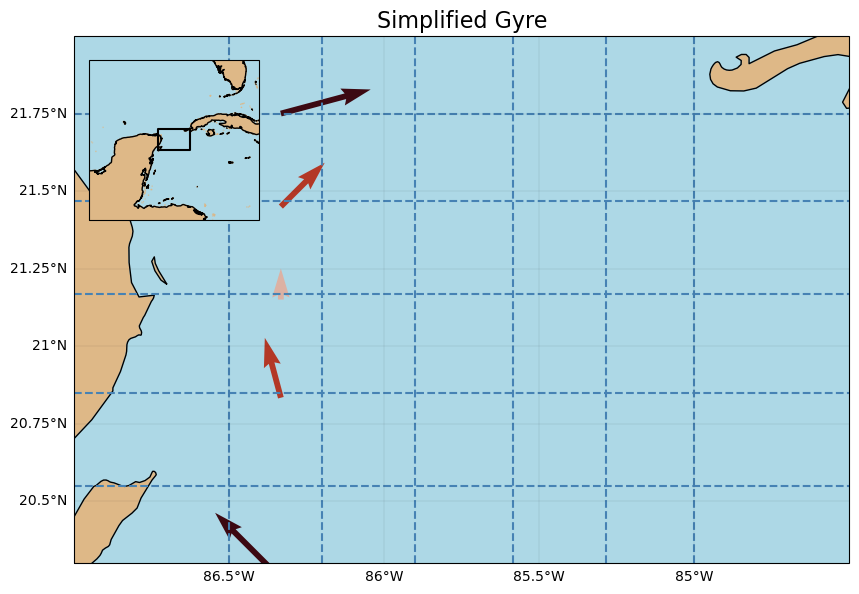

In [86]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import glob as glob
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.crs as ccrs
# import cool_maps.plot as cplt
import cmocean.cm as cmo

start_lon   = -86.5
end_lon     = -85
start_lat   = 20.25
end_lat     = 21.76
filename = 'sfmc_simpleGyre.xml'
wheresave = '../SFMC_script/'
complete_filename = os.path.join(wheresave,filename)

# for longitude
def decimal_degrees_to_degrees_minutes(start_lon,end_lon):
    range_str = []
    unique_strings = []
    lon_map = []

    range_run = np.arange(start_lon, end_lon, 0.01) # range of numbers with 0.01 steps

    for i in range_run:
        deg = int(i)
        decimal_part = abs(i - deg)
        min = int(decimal_part * 60)
        # Formatting minutes to have leading zero if necessary
        min_str = f'{min:02d}'  # This ensures minutes are represented with leading zero if < 10
        string = f'{deg}{min_str}'

        # str = f'{deg}{min}'
        range_str.append(string)

    for string in range_str:
        if string not in unique_strings:
            unique_strings.append(string)
    
    # longitude strings to integers for mapping later
    for lon_str in unique_strings:
        londegstr = lon_str[1:3]  # Extracting degrees part without the negative sign
        lonminstr = lon_str[3:]   # Extracting minutes part for negative longitude
        lon_maploop = - (int(londegstr) + (int(lonminstr) / 60))

        lon_map.append(lon_maploop)

    return unique_strings,lon_map

# for latitude
def latitude_parse(start_lat,end_lat):
    range_str = []
    unique_strings = []
    lon_map = []

    range_run = np.arange(start_lat, end_lat, 0.01) # range of numbers with 0.01 steps

    for i in range_run:
        deg = int(i)
        decimal_part = abs(i - deg)
        min = int(decimal_part * 60)
        # Formatting minutes to have leading zero if necessary
        min_str = f'{min:02d}'  # This ensures minutes are represented with leading zero if < 10
        string = f'{deg}{min_str}'
        # print(string)
        # str = f'{deg}{min}'
        range_str.append(string)

    for string in range_str:
        if string not in unique_strings:
            unique_strings.append(string)
    
    # longitude strings to integers for mapping later
    for lon_str in unique_strings:
        londegstr = lon_str[0:2]  # Extracting degrees part without the negative sign
        lonminstr = lon_str[2:]   # Extracting minutes part for negative longitude
        # print(lonminstr)
        lon_maploop = (int(londegstr) + (int(lonminstr) / 60))
        lon_map.append(lon_maploop)

    return unique_strings,lon_map

# sections, 20, 20, 20, 15, 16
sec0 = 18
sec1 = 18
sec2 = 19
sec3 = 18
sec4 = 18

pltsec0 = 0
pltsec1 = sec0+sec1-1
pltsec2 = sec0+sec1+sec2-1
pltsec3 = sec0+sec1+sec2+sec3-1
pltsec4 = sec0+sec1+sec2+sec3+sec4-1

# west0 = [45]*sec0
# west1 = [90]*sec1
# west2 = [135]*sec2
# west3 = [180]*sec3
# west4 = [225]*sec4
# water_dir_deg = west0+west1+west2+west3+west4

# lon sec 0
area0_0 = [315]*sec0
area0_1 = [345]*sec1
area0_2 = [0]*sec2
area0_3 = [45]*sec3
area0_4 = [75]*sec4
area0_water_dir_deg = area0_0 + area0_1 + area0_2 + area0_3 + area0_4

area0_rads = []
for i in area0_water_dir_deg:
    rads_loop = math.radians(i)
    area0_rads.append(rads_loop)

# lon sec 1
area1_0 = [315]*sec0
area1_1 = [345]*sec1
area1_2 = [0]*sec2
area1_3 = [45]*sec3
area1_4 = [75]*sec4
area1_water_dir_deg = area1_0 + area1_1 + area1_2 + area1_3 + area1_4

area1_rads = []
for i in area0_water_dir_deg:
    rads_loop = math.radians(i)
    area1_rads.append(rads_loop)

# lon sec 2
area2_0 = [315]*sec0
area2_1 = [345]*sec1
area2_2 = [0]*sec2
area2_3 = [45]*sec3
area2_4 = [75]*sec4
area2_water_dir_deg = area2_0 + area2_1 + area2_2 + area2_3 + area2_4

area2_rads = []
for i in area0_water_dir_deg:
    rads_loop = math.radians(i)
    area2_rads.append(rads_loop)

# lon sec 3
area3_0 = [315]*sec0
area3_1 = [345]*sec1
area3_2 = [0]*sec2
area3_3 = [45]*sec3
area3_4 = [75]*sec4
area3_water_dir_deg = area3_0 + area3_1 + area3_2 + area3_3 + area3_4

area3_rads = []
for i in area0_water_dir_deg:
    rads_loop = math.radians(i)
    area3_rads.append(rads_loop)

# lon sec 4
area4_0 = [315]*sec0
area4_1 = [345]*sec1
area4_2 = [0]*sec2
area4_3 = [45]*sec3
area4_4 = [75]*sec4
area4_water_dir_deg = area4_0 + area4_1 + area4_2 + area4_3 + area4_4

area4_rads = []
for i in area0_water_dir_deg:
    rads_loop = math.radians(i)
    area4_rads.append(rads_loop)

speed0 = [0.6]*sec0
speed1 = [0.4]*sec1
speed2 = [0.2]*sec2
speed3 = [0.4]*sec3
speed4 = [0.6]*sec4

water_speed = speed0 + speed1 + speed2 + speed3 + speed4

lon_range_str,lon_map = decimal_degrees_to_degrees_minutes(start_lon,end_lon)
loopnum = len(lon_range_str)
# lat_map = [21]*len(lon_map)

lat_range_str,lat_map = latitude_parse(start_lat,end_lat)

print(f'Length of things should be equal: {len(lon_map)} = {len(lon_range_str)} = {len(rads)} = {len(water_speed)} = {len(lat_map)}')

lon_ext = [-86.5,-85]
lat_ext = [21.5,20.8] 

# Create a map using PlateCarree projection (latitude and longitude)
fig, ax = plt.subplots(figsize=(10,20),subplot_kw={'projection': ccrs.PlateCarree()})
# fig, ax = cplt.create(extent, proj=ccrs.Mercator(), bathymetry=False, figsize=(10,20))

buffer = 0.5
# Set the extent of the map based on the trackline data
ax.set_extent([min(lon_ext) - buffer,
                max(lon_ext) + buffer, 
                min(lat_ext) - buffer, 
                max(lat_ext) + buffer
                ])

# Add coastlines
ax.coastlines()
ax.add_feature(cfeature.LAND, color='burlywood') # I like this color
ax.add_feature(cfeature.OCEAN, color='lightblue')

gl = ax.gridlines(draw_labels=True, linewidth=0.1, color='black', alpha=0.5, linestyle='-')
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right labels

# remove labels from ax.gridlines
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# remove labels from cartopy
ax.set_xticklabels([])
ax.set_yticklabels([])

color = 'steelblue'
# sections, 20, 20, 20, 15, 16
ax.axvline(lon_map[sec0], color=color, linestyle='--')
ax.axvline(lon_map[sec0+sec1], color=color, linestyle='--')
ax.axvline(lon_map[sec0+sec1+sec2], color=color, linestyle='--')
ax.axvline(lon_map[sec0+sec1+sec2+sec3], color=color, linestyle='--')
ax.axvline(lon_map[sec0+sec1+sec2+sec3+sec4-1], color=color, linestyle='--')

# Define colormap
cmap = cmo.amp
# cmap = cmap.reversed()

# Define the range of values corresponding to the colormap
pltspeed_values = [0.1, 0.3, 0.4, 0.6]  

# # Create a scalar mappable for colorbar
norm = plt.Normalize(min(pltspeed_values), max(pltspeed_values))
scalar_mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scalar_mappable.set_array([])  # Set an empty array

scale = 5 # was 3.1 bigger num is smaller

# Convert direction and magnitude to components (u, v)
area0_u_list = []  # Empty list to store u components
area0_v_list = []  # Empty list to store v components

for speed, rad in zip(water_speed, area0_rads):
    # Adjust the angles for the quiver plot if needed
    adjusted_rads = [np.pi / 2 - angle for angle in area0_rads]
    
    u = speed * np.cos(adjusted_rads)
    v = speed * np.sin(adjusted_rads)
    area0_u_list.append(u)
    area0_v_list.append(v)
    
# Plot the quiver plots using colormap
quiver0 = ax.quiver(lon_map[pltsec0+10], lat_map[pltsec0], area0_u_list[pltsec0][pltsec0], area0_v_list[pltsec0][pltsec0],
                    angles='xy', color=cmap(norm(0.6)), transform=ccrs.PlateCarree(), scale=scale)
quiver1 = ax.quiver(lon_map[pltsec0+10], lat_map[pltsec1], area0_u_list[pltsec1][pltsec1], area0_v_list[pltsec1][pltsec1],
                    angles='xy', color=cmap(norm(0.4)), transform=ccrs.PlateCarree(), scale=scale)
quiver2 = ax.quiver(lon_map[pltsec0+10], lat_map[pltsec2], area0_u_list[pltsec2][pltsec2], area0_v_list[pltsec2][pltsec2],
                    angles='xy', color=cmap(norm(0.2)), transform=ccrs.PlateCarree(), scale=scale)
quiver3 = ax.quiver(lon_map[pltsec0+10], lat_map[pltsec3], area0_u_list[pltsec3][pltsec3], area0_v_list[pltsec3][pltsec3],
                    angles='xy', color=cmap(norm(0.4)), transform=ccrs.PlateCarree(), scale=scale)
quiver4 = ax.quiver(lon_map[pltsec0+10], lat_map[pltsec4], area0_u_list[pltsec4][pltsec4], area0_v_list[pltsec4][pltsec4],
                    angles='xy', color=cmap(norm(0.6)), transform=ccrs.PlateCarree(), scale=scale)

plt.title('Simplified Gyre',fontsize=16)
# this at end for bottom of legend
ax.axvline(lon_map[0], color='steelblue', linestyle='--',label='Boundaries')

# locator map
# left, bottom, width, height
ax_locator = fig.add_axes([0.14, 0.49, 0.17, 0.17], projection=ccrs.PlateCarree())

big_extent_buff = 6
big_extent = ([min(lon_ext) - big_extent_buff,
                max(lon_ext) + big_extent_buff,
                min(lat_ext) - big_extent_buff,
                max(lat_ext) + big_extent_buff])
# set extent for the locator map
ax_locator.set_extent(big_extent)
ax_locator.add_feature(cfeature.COASTLINE, edgecolor='black')
ax_locator.add_feature(cfeature.OCEAN, color='lightblue')
ax_locator.add_feature(cfeature.LAND, color='burlywood')

# ax.scatter(lon_glider, lat_glider, marker='.', s=20, alpha=0.5, cmap='cool', transform=ccrs.PlateCarree())
# ax.plot(lon_glider_e, lat_glider_e, linewidth=1.5, color='black', transform=ccrs.PlateCarree(),label='Due east')
# ax.plot(lon_glider_se, lat_glider_se, linewidth=1.5, color='red', transform=ccrs.PlateCarree(),label='Southeast')
# ax.plot(lon_glider_spec1, lat_glider_spec1, linewidth=1.5, color='forestgreen', transform=ccrs.PlateCarree(),label='Backseat Driver')

## Box around actual figure region
ax_locator.plot([min(lon_ext) - buffer, min(lon_ext) - buffer,  max(lon_ext) + buffer, max(lon_ext) + buffer, min(lon_ext) - buffer] , 
        [min(lat_ext) - buffer, max(lat_ext) + buffer, max(lat_ext) + buffer, min(lat_ext) - buffer, min(lat_ext) - buffer], color='black',linewidth=1.5,  transform=ccrs.PlateCarree())

ax.set_extent([min(lon_ext) - buffer,
                max(lon_ext) + buffer, 
                min(lat_ext) - buffer, 
                max(lat_ext) + buffer
                ])

# ax.legend(loc='lower right')
# bbox_time = dict(boxstyle='square,pad=0.5', facecolor='white', alpha=0.5)  # Semi-transparent white box
# ax.text(-85.2,21.65,f'{t_e}',fontsize=12,bbox=bbox_time)     # due east time
# ax.text(-85.17,21.1,f'{t_se}',fontsize=12,bbox=bbox_time)     # southeast time
# ax.text(-85,21.4,f'{t_spec1}',fontsize=12,bbox=bbox_time) # spec1 time

ax.axhline(lat_map[sec0], color=color, linestyle='--')
ax.axhline(lat_map[sec0+sec1], color=color, linestyle='--')
ax.axhline(lat_map[sec0+sec1+sec2], color=color, linestyle='--')
ax.axhline(lat_map[sec0+sec1+sec2+sec3], color=color, linestyle='--')
ax.axhline(lat_map[sec0+sec1+sec2+sec3+sec4-1], color=color, linestyle='--')

plt.savefig(os.path.join(wheresave,'simple_gyre.png'), dpi=300, bbox_inches='tight')
# filename = os.path.join(wheresave,'sendWaterSpeedDir.png')
# print(f'plot_fzb saved: {filename}')